## Comparing response times of different genetic diversity metrics from a high (0.65) or low (0.30) initial prevalence

In [1]:
import os
import sys
import getopt
import json
from datetime import datetime
import pandas as pd
import numpy as np

from lib.preferences import *
from lib.response import *
from lib.plotting import *

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for legend
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.dpi'] = 100

## Settings

In [2]:
genetic_metrics = list(genetic_names.keys())
genetic_names.update(op_names)

In [3]:
output_dir = "../figs/review/analysis_cf-detection"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
savefig = True

## Load data

In [4]:
input_dir = "../analysis"
expt = "nv"
focus = "crash"
stat = "detection"

In [5]:
titles = {
    "gamma": "Vary Clearance Rate ($\gamma$)",
    "nv": "Vary No. Vectors ($N_V$)",
    "bite_rate_per_v": "Vary Bite Rate ($b$)"
}
xlabs = {
    "detection" : "Detection Time [Years]",
    "equilibrium" : "Equilibrium Time [Years]"
}

intv_names = {
    "base" : "High PfPR (%.02f-%.02f)" % (0.65, 0.2),
    "low" : "Low PfPR (%.02f-%.02f)" % (0.3, 0.1)
}

In [6]:
df = pd.read_csv(os.path.join(input_dir, 
                              "2021-02-08_intv-%s" % expt, 
                              "response",
                              "%s_%s.csv" % (focus, stat))) 

In [7]:
low_df = pd.read_csv(os.path.join(input_dir, 
                                  "2021-02-15_intv-low-%s" % expt, 
                                  "response",
                                  "%s_%s.csv" % (focus, stat))) 

## Munge data

In [8]:
dfm = pd.melt(df)
dfm.insert(2, "expt", "base")
low_dfm = pd.melt(low_df)
low_dfm.insert(2, "expt", "low")
merged_df = pd.concat([dfm, low_dfm])

In [9]:
# Make metrics categorical and ordered
metrics = merged_df.variable.unique()
merged_df["variable"] = pd.Categorical(
    merged_df["variable"], metrics, ordered=True)
merged_df["value"] /= 365

In [10]:
# Compute means
mus = merged_df.groupby(["variable", "expt"]).median()
ranks = mus.groupby("expt").rank(method="first")

In [11]:
annot = pd.merge(left=mus, right=ranks, left_index=True, right_index=True)
annot.columns = ["mean", "rank"]
annot.head()

mean  rank
variable           expt                
HX                 base  0.109848   1.0
                   low   0.620804   1.0
VX                 base  0.219804   2.0
                   low   0.974226   2.0
frac_mixed_samples base  0.481352   3.0

## Plot data

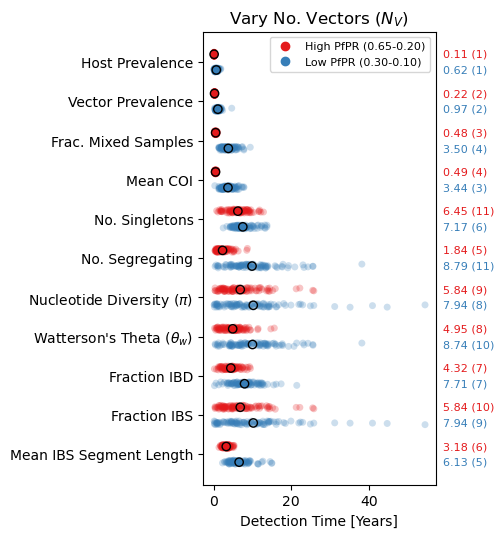

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3, 6))

# Stripplot
sp = sns.stripplot(x="value", y="variable", hue="expt",
                   orient="horizontal",
                   palette="Set1",
                   alpha=0.25,
                   dodge=True,
                   zorder=0,
                   data=merged_df)

# Means
mus = merged_df.groupby(["variable", "expt"]).mean()
dodge=0.2
# Base
ax.scatter(y=sp.get_yticks() - dodge,
           x=mus.query("expt == 'base'"),
           marker="o",
           color='none',
           edgecolor="black",
           zorder=6)
# Low
ax.scatter(y=sp.get_yticks() + dodge,
           x=mus.query("expt == 'low'"),
           marker="o",
           color='none',
           edgecolor="black",
           zorder=6)

# Annotate
# Base
for i, (m, v) in enumerate(annot.query("expt=='base'").iterrows()):
    ax.annotate(xy=(sp.get_xlim()[1], sp.get_yticks()[i] - dodge),
                xycoords="data",
                ha="left", va="center",
                color=sns.color_palette("Set1", 2)[0],
                fontsize=8,
                text="  %.2f (%d)" % (v["mean"], v["rank"]))
# Low
for i, (m, v) in enumerate(annot.query("expt=='low'").iterrows()):
    ax.annotate(xy=(sp.get_xlim()[1], sp.get_yticks()[i] + dodge),
                xycoords="data",
                ha="left", va="center",
                color=sns.color_palette("Set1", 2)[1],
                fontsize=8,
                text="  %.2f (%d)" % (v["mean"], v["rank"]))

# Labels
ax.set_ylabel("")
ax.set_xlabel(xlabs[stat])
ax.set_title(titles[expt])

# Legend
handles = [Line2D([0],[0], marker='o', lw=0, color=c, label=n)
           for c, n in zip(sns.color_palette("Set1", 2), intv_names.values())]
ax.legend(handles=handles, fontsize=8)

ax.set_yticklabels([genetic_names[m.get_text()] for m in ax.get_yticklabels()])

if savefig:
    fig.savefig(os.path.join(output_dir, 
                             "%s_%s-%s_stripplot.png" % (expt, focus, stat)),
                bbox_inches="tight", pad_inches=0.5)

### Rank chart

In [13]:
annot = annot.reset_index()
n_metrics = annot.variable.unique().size
n_metrics

11

/anaconda2/envs/dream/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


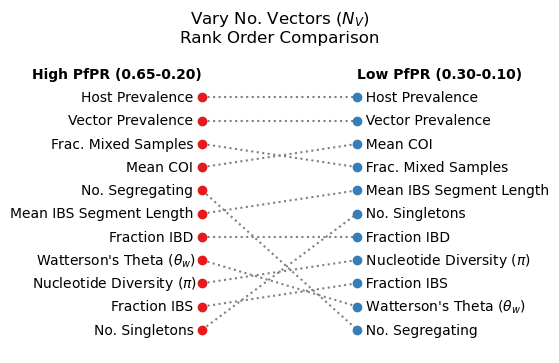

In [14]:
fig, ax = plt.subplots(1, 1)

# Before
before = annot.query("expt == 'base'")
before.sort_values("rank", inplace=True)
bx = np.repeat(1, n_metrics)
ax.scatter(x=bx, y=before["rank"], color=sns.color_palette("Set1", 2)[0])
for n, row in before.iterrows():
    ax.annotate(xy=(1, row["rank"]),
                xycoords="data",
                ha="right", va="center",
                text="%s  " % genetic_names[row["variable"]])
ax.annotate(xy=(1, 0),
            xycoords="data",
            ha="right", va="center",
            text=intv_names["base"], weight="bold")
    
# After
after = annot.query("expt == 'low'")
afx = np.repeat(2, n_metrics)
ax.scatter(x=afx, y=after["rank"], color=sns.color_palette("Set1", 2)[1])
for n, row in after.iterrows():
    ax.annotate(xy=(2, row["rank"]),
                xycoords="data",
                ha="left", va="center",
                text="  %s" % genetic_names[row["variable"]])
ax.annotate(xy=(2, 0),
            xycoords="data",
            ha="left", va="center",
            text=intv_names["low"], weight="bold")
    
    
# Lines
for m in metrics:
    ax.plot([1, 2], 
            [before.query("variable == @m")["rank"],
             after.query("variable == @m")["rank"]],
            color='grey', zorder=-10, linestyle='dotted'
           )

# Limits
ax.set_xlim(0, 3)
ax.set_ylim(-1, n_metrics+1)
ax.invert_yaxis()

# Title
ax.set_title(titles[expt]+"\nRank Order Comparison")

# Axis
plt.axis("off")


if savefig:
    fig.savefig(os.path.join(output_dir, 
                             "%s_%s-%s_rankplot.png" % (expt, focus, stat)),
                bbox_inches="tight", pad_inches=0.5)

### Scatterplot comparison

In [15]:
mu_df = (mus
         .reset_index()
         .pivot(columns="expt", index="variable")
         .reset_index()
        )
mu_df.columns = mu_df.columns.droplevel()
mu_df.columns = ["metric", "base", "low"]
mu_df

,metric,base,low
0,HX,0.116978,0.676657
1,VX,0.226093,1.074747
2,frac_mixed_samples,0.508502,3.783021
3,mean_k,0.485135,3.689642
4,n_singletons,6.243392,7.517655
5,n_segregating,2.296661,9.893522
6,pi,6.853762,10.212430
7,theta,4.907630,10.013720
8,f_ibd,4.428307,7.959402
9,f_ibs,6.853762,10.212430


In [16]:
n = len(mu_df["metric"][2:])

In [17]:
metric_col_dt = dict(zip(mu_df["metric"][2:], sns.color_palette("Paired", n)))
metric_col_dt.update({
    "HX": (0.8, 0.8, 0.8),
    "VX": (0.4, 0.4, 0.4)
    })

In [18]:
def abline(a, b, ax):
    """
    Plot a line with an arbitary slope `b`
    and intercept `a`
    """
    xs = np.array(ax.get_xlim())
    ys = a + b * xs
    ax.plot(xs, ys, ls='dashed', zorder=-1, color='grey')

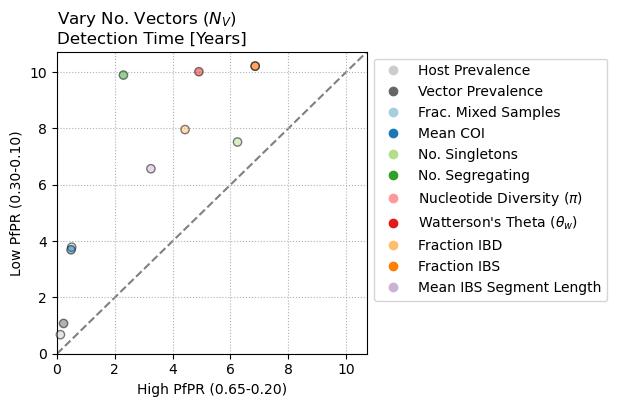

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# Plot
ax.scatter(x=mu_df["base"], 
           y=mu_df["low"],
           c=[metric_col_dt[m] for m in mu_df["metric"]],
           ec='black', alpha=0.5,
           zorder=10, clip_on=False)

# Labels
ax.set_xlabel(intv_names["base"])
ax.set_ylabel(intv_names["low"])
ax.set_title("%s\n%s" % (titles[expt], xlabs[stat]), loc="left")

# 1:1
vmax = max(np.concatenate([mu_df["base"], mu_df["low"]]))
ax.set_xlim((0, vmax*1.05))
ax.set_ylim((0, vmax*1.05))
abline(0, 1, ax)


# Grid
ax.grid(ls='dotted')

handles = [Line2D([0], [0], color=metric_col_dt[m], lw=0, marker='o', label=genetic_names[m])
           for m in mu_df["metric"]]
ax.legend(bbox_to_anchor=(1, 1), handles=handles, ncol=1)

if savefig:
    fig.savefig(os.path.join(output_dir, 
                             "%s_%s-%s_scatterplot.png" % (expt, focus, stat)),
                bbox_inches="tight", pad_inches=1.0)

## Focus on no. segregating sites vs. IBD Fraction

In [20]:
df /= 365  # convert to years
low_df /= 365

### Q-Q

Text(0.0, 1.0, 'Low PfPR Q-Q Plot\nDetection Time [Years]')

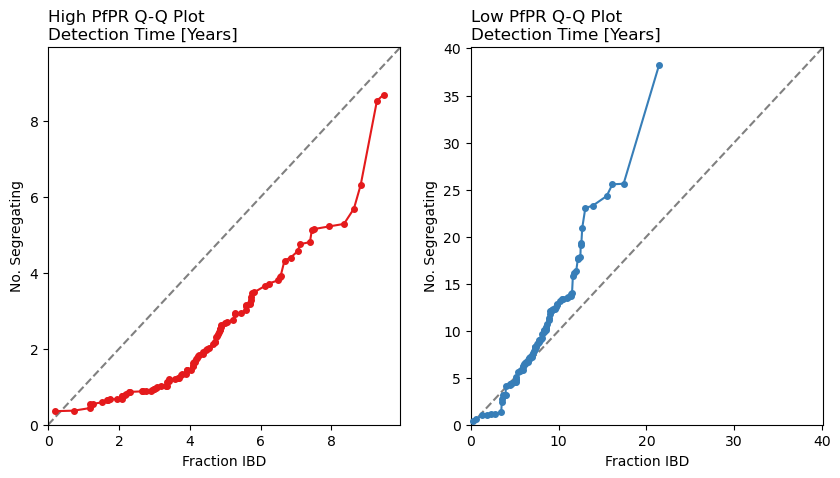

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Base
ax[0].plot(df["f_ibd"].sort_values(), 
           df["n_segregating"].sort_values(),
           marker='o', ms=4,
           zorder=10, clip_on=False,
           color=sns.color_palette("Set1", 2)[0], label="base")
# 1:1
vmax = max(np.concatenate([df["f_ibd"], df["n_segregating"]]))
ax[0].set_xlim((0, vmax*1.05))
ax[0].set_ylim((0, vmax*1.05))
abline(0, 1, ax[0])
# Labels
ax[0].set_xlabel(genetic_names["f_ibd"])
ax[0].set_ylabel(genetic_names["n_segregating"])
ax[0].set_title("High PfPR Q-Q Plot\n" + xlabs[stat], loc="left")

# Low
ax[1].plot(low_df["f_ibd"].sort_values(), 
           low_df["n_segregating"].sort_values(),
           marker='o', ms=4,
           zorder=10, clip_on=False,
           color=sns.color_palette("Set1", 2)[1], label="base")
# 1:1
vmax = max(np.concatenate([low_df["f_ibd"], low_df["n_segregating"]]))
ax[1].set_xlim((0, vmax*1.05))
ax[1].set_ylim((0, vmax*1.05))
abline(0, 1, ax[1])
# Labels
ax[1].set_xlabel(genetic_names["f_ibd"])
ax[1].set_ylabel(genetic_names["n_segregating"])
ax[1].set_title("Low PfPR Q-Q Plot\n" + xlabs[stat], loc="left")

### Histogram

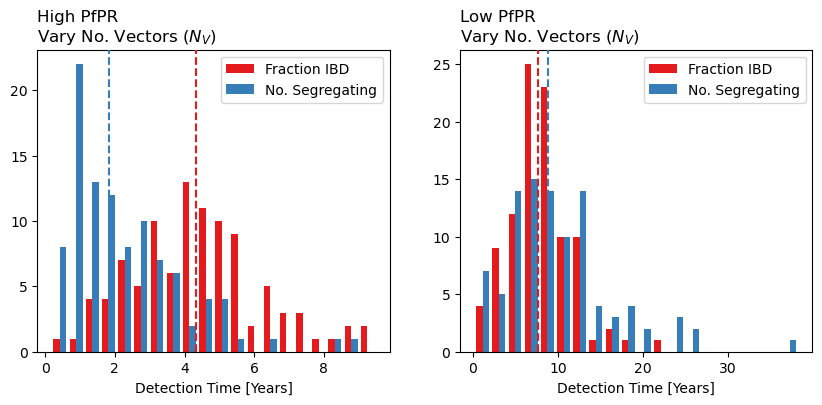

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

focus_metrics = ["f_ibd", "n_segregating"]

# Normal
ax[0].hist([df[m] for m in focus_metrics],
           color=sns.color_palette("Set1", len(focus_metrics)),
           label=[genetic_names[m] for m in focus_metrics],
           bins=20)
for i, m in enumerate(focus_metrics):
    ax[0].axvline(df[m].median(), 
               color=sns.color_palette("Set1", len(focus_metrics))[i],
               ls='dashed', zorder=3)
ax[0].set_xlabel(xlabs[stat])
ax[0].set_title("High PfPR\n"+titles[expt], loc="left")
ax[0].legend()

# Low
ax[1].hist([low_df[m] for m in focus_metrics],
           color=sns.color_palette("Set1", len(focus_metrics)),
           label=[genetic_names[m] for m in focus_metrics],
           bins=20)
for i, m in enumerate(focus_metrics):
    ax[1].axvline(low_df[m].median(), 
                  color=sns.color_palette("Set1", len(focus_metrics))[i],
                  ls='dashed', zorder=3)
ax[1].set_xlabel(xlabs[stat])
ax[1].set_title("Low PfPR\n"+titles[expt], loc="left")
ax[1].legend()